### The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. 

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from preprocessing import mean_and_std
from regression_models import dosomething

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
outliers_df = pd.read_csv('geocoded.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    2400 non-null   int64  
 1   bed             2400 non-null   float64
 2   bath            2400 non-null   float64
 3   acre_lot        2400 non-null   float64
 4   zip_code        2400 non-null   float64
 5   house_size      2400 non-null   float64
 6   prev_sold_date  2400 non-null   object 
 7   price           2400 non-null   float64
 8   prev_sold_year  2400 non-null   int64  
 9   zip_code_str    2400 non-null   int64  
 10  latitude        2400 non-null   float64
 11  longitude       2400 non-null   float64
 12  county          2400 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 243.9+ KB


#### Create an object to pass to the function that will normalize the data

In [4]:
params = {
    "data":outliers_df,
    "features_a":["prev_sold_year","zip_code","latitude","longitude"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
#normalize_df = outliers_df
normalize_df.tail()

,Unnamed: 0.1,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude,county
2395,2395,2.0,2.0,0.17,6907.0,1031.0,2020-01-02,349900.0,2020,6907,41.100918,-73.520517,16
2396,2396,3.0,3.0,0.17,6907.0,1738.0,2017-10-18,469000.0,2017,6907,41.100918,-73.520517,16
2397,2397,1.0,1.0,0.17,6907.0,844.0,2018-12-27,275000.0,2018,6907,41.100918,-73.520517,16
2398,2398,3.0,4.0,1.00,6896.0,2471.0,2019-07-08,729000.0,2019,6896,41.305415,-73.392584,10
2399,2399,3.0,4.0,0.17,6896.0,2408.0,2017-06-27,750000.0,2017,6896,41.305415,-73.392584,10


#### Create a variable for the correlation of the normalized data

In [5]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.108466
bed               0.311940
bath              0.570421
house_size        0.593417
prev_sold_year   -0.003477
price             1.000000
Name: price, dtype: float64

#### Display a Heatmap with the correlated data

Text(0.5, 1.0, 'Correlation Between Variables')

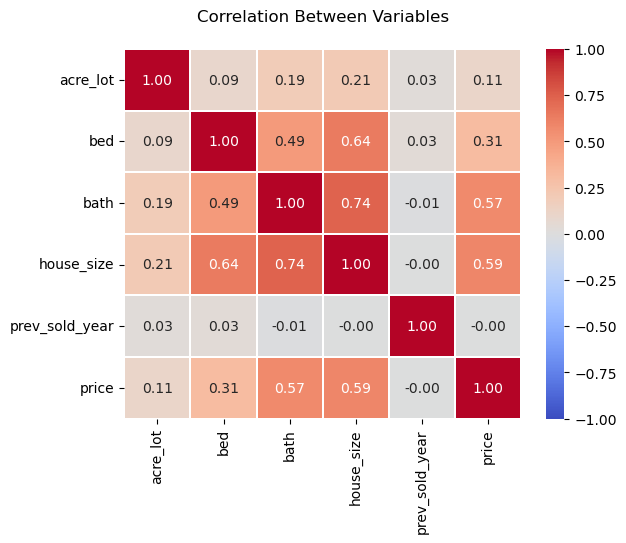

In [6]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

#### Create a variable to hold the features that correlate with the price feature between 0.20 and 0.80

In [7]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'bed', 'bath', 'house_size']


#### Create common variables to store frequently used values.

In [8]:
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [9]:
X = normalize_df[features]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [10]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [11]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

#### Use Grid Search CV to find the best Hyperparameters for Lasso Regression

In [12]:
myrange = []
for i in range(12,17):
    myrange.append(10**-i)
param_dict = {'alpha': myrange}
lasso_gscv = GridSearchCV(Lasso(), param_grid=param_dict, scoring='neg_mean_squared_error')
lasso_gscv_model = lasso_gscv.fit(X, y)
print(f"Best parameters found: {lasso_gscv.best_params_}")

Best parameters found: {'alpha': 1e-14}


#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [13]:
lasso_bp = dosomething("Lasso","Best Params", normalize_df, features, "price", lasso_gscv.best_params_)
results_dict_append(lasso_bp["results"])
lasso_bp_predict = lasso_bp["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Best Params EVS = 0.543668583
Best Params MSE = 65,956,804,870.511917
Best Params MAE = 161,415.507137
Best Params R2 = 0.543033
Best Params Fit Time = 0.005729103088378906


### SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute or via an importance_getter callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter.

In [14]:
lasso_sfm = dosomething("Lasso","Select From Model", normalize_df, features, "price")
results_dict_append(lasso_sfm["results"])
lasso_sfm_predict = lasso_sfm["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Select From Model EVS = 0.543667469
Select From Model MSE = 65,956,962,680.225174
Select From Model MAE = 161,414.537152
Select From Model R2 = 0.543032
Select From Model Fit Time = 0.0


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [15]:
lasso_sfs = dosomething("Lasso","Sequential Feature Selector", normalize_df, features, "price")
results_dict_append(lasso_sfs["results"])
lasso_sfs_predict = lasso_sfs["predictions"]

The selected features are: ['longitude', 'bed', 'bath', 'house_size']
Sequential Feature Selector EVS = 0.481667819
Sequential Feature Selector MSE = 74,825,469,327.565704
Sequential Feature Selector MAE = 166,551.563673
Sequential Feature Selector R2 = 0.481589
Sequential Feature Selector Fit Time = 0.0


### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [16]:
lasso_rfe = dosomething("Lasso","Recursive Feature Elimination", normalize_df, features, "price")
results_dict_append(lasso_rfe["results"])
lasso_rfe_predict = lasso_rfe["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath']
Recursive Feature Elimination EVS = 0.485148015
Recursive Feature Elimination MSE = 74,359,301,827.326828
Recursive Feature Elimination MAE = 174,671.744413
Recursive Feature Elimination R2 = 0.484819
Recursive Feature Elimination Fit Time = 0.0


#### Graphing the results works best when the data is provided in a DataFrame.

In [17]:
lasso_bp_predict_df = pd.DataFrame(lasso_bp_predict).reset_index()
lasso_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_sfm_predict_df = pd.DataFrame(lasso_sfm_predict).reset_index()
lasso_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_sfs_predict_df = pd.DataFrame(lasso_sfs_predict).reset_index()
lasso_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_rfe_predict_df = pd.DataFrame(lasso_rfe_predict).reset_index()
lasso_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

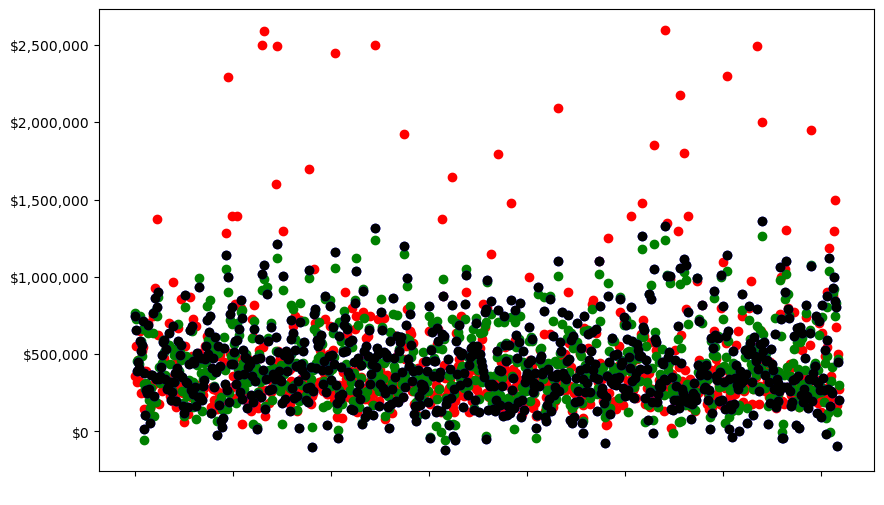

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(lasso_sfs_predict_df.index,lasso_sfs_predict_df["prediction"], color="green")
plt.scatter(lasso_sfm_predict_df.index,lasso_sfm_predict_df["prediction"], color="blue")
plt.scatter(lasso_bp_predict_df.index,lasso_bp_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [19]:
results_dict

{'model': ['Best Params',
  'Select From Model',
  'Sequential Feature Selector',
  'Recursive Feature Elimination'],
 'explained variance score': ['0.543668583',
  '0.543667469',
  '0.481667819',
  '0.485148015'],
 'mae score': ['161,415.507137',
  '161,414.537152',
  '166,551.563673',
  '174,671.744413'],
 'mse score': ['65,956,804,870.511917',
  '65,956,962,680.225174',
  '74,825,469,327.565704',
  '74,359,301,827.326828'],
 'r2 score': ['0.543033', '0.543032', '0.481589', '0.484819'],
 'mean fit time': [0.005729103088378906, 0.0, 0.0, 0.0]}

In [20]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Best Params,0.543668583,"161,415.507137","65,956,804,870.511917",0.543033,0.005729
Select From Model,0.543667469,"161,414.537152","65,956,962,680.225174",0.543032,0.000000
Sequential Feature Selector,0.481667819,"166,551.563673","74,825,469,327.565704",0.481589,0.000000
Recursive Feature Elimination,0.485148015,"174,671.744413","74,359,301,827.326828",0.484819,0.000000
